In [126]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Softmax, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import tensorflow as tf
import datetime
import tensorboard
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np
from imblearn.over_sampling import SMOTE


#array de colunas


In [127]:
weeks1 = pd.read_csv('../data_raw/dados/2016-1/tabela processada nota media mediana iteracao.csv')
features = ['Aprovado']

for i in range(18):
  features.append(f'Week{i}')
  features.append(f'MedianaW{i}')
  features.append(f'MediaW{i}')
how = ['first']

for i in range(18*3):
  how.append(f'last')

dict_agg = dict(zip(features,how))

weeks2_semnotas = pd.read_csv('../data_raw/dados/2016-2/tabela final .csv')
weeks2_comnotas = pd.read_csv('../data_raw/dados/2016-2/tabela de iteracoes com nota add.csv')
#weeks2 = weeks2_semnotas.join(weeks2_comnotas,on='Nome',how='inner')
weeks2_raw = pd.concat([weeks2_semnotas, weeks2_comnotas])
weeks2 = weeks2_raw.groupby(weeks2_raw['Nome']).agg(dict_agg)
weeks2.dropna(inplace=True)
weeks3 = pd.read_csv('../data_raw/dados/2017-1/tabela final.csv')
weeks4 = pd.read_csv('../data_raw/dados/2017-2/tabela com media mediana e interacao e nota.csv')

weeks_raw =  pd.concat([weeks1, weeks2, weeks3, weeks4])


In [128]:
def weeks_formating(weeks):
  
  weeks.fillna(0, inplace=True)
  weeks.drop(['Unnamed: 0.1','Notas', 'Unnamed: 0', 'Nome'], inplace=True, axis=1)
  weeks['Aprovado'] = pd.Categorical(weeks['Aprovado'])
  weeks['Aprovado'] = weeks.Aprovado.cat.codes
  weeks = (weeks
          .replace('\$\s+','', regex=True)
          .astype(float)
          .applymap('{:.2f}'.format))
  weeks = weeks.astype(float)
  weeks_lbl = weeks['Aprovado']
  count_zero = (weeks['Aprovado'] == 0).sum()
  count_one = (weeks['Aprovado'] == 1).sum()
  print(count_zero, count_one)
  return weeks, weeks_lbl

In [129]:
def oversample_data(X_train, y_train):
  smote = SMOTE(random_state = 101)
  X_oversample, y_oversample = smote.fit_resample(X_train, y_train)
  return X_oversample, y_oversample

In [130]:
def weeks_data(data, weeks_num):

  features = []

  for i in range(weeks_num):
    features.append(f'Week{i}')
    features.append(f'MedianaW{i}')
    features.append(f'MediaW{i}')
    
  features.append(f'Aprovado')
  features.remove('Aprovado')
  weeks = data[features]
  weeks = weeks.to_numpy()
  return weeks

In [131]:
def build_model(weeks_num):
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = Sequential()
    model.add(LSTM(30, input_shape=(weeks_num, 3)))
    model.add(Dense(1, activation='sigmoid'))
    #model.add(Softmax(1))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
    return model


35 87


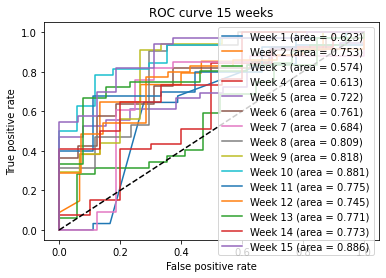

In [132]:
weeks_num = 15
weeks, label = weeks_formating(weeks_raw)

for i in range(weeks_num):

  data = weeks_data(weeks, i+1)

  X, y = data, label

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
  X_train_oversampled, y_train_oversampled = oversample_data(X_train, y_train)

  X_train_oversampled = X_train_oversampled.reshape(len(X_train_oversampled), i+1, 3)
  X_test = X_test.reshape(len(X_test), i+1, 3)


  model = build_model(i+1)


  model.fit(x=X_train_oversampled,
           y=y_train_oversampled,
           batch_size=3,  
           epochs=10, 
           verbose=0)

  y_pred_keras = model.predict(X_test).ravel()
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.plot(fpr_keras, tpr_keras, label='Week {} (area = {:.3f})'.format(i+1, auc_keras))
  
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 15 weeks')
plt.legend(loc='best')
plt.show()